# Tabulated Example

To run this tutorial, you should install NEoST following the install guide. Some extra data files are also required, these are the `ap4_new.dat` file and is included in the GitHub repository along with this notebook.

Before continuing with this tutorial, please read the inference process overview to familiarise yourself with the way NEoST parametrises the equation of state.

The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

In [1]:
import neost
import kalepy
from neost.eos import speedofsound, tabulated
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot
from pymultinest.solve import solve
import time
import os

import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

# Define name for run, extra - at the end is for nicer formatting of output
run_name = "tabulated_AP4_test_2D_gaussian"

using c code


Defining and loading in the AP4 nuclear equation of state

In [2]:
eos_name = 'tabulated'

baryondensity, pressure_B, energydensity_B = np.loadtxt('../../examples/ap4_new.dat', unpack=True) #in units of g/cm^3 for all values

pressure_B = pressure_B*c**2 #(in units of g/(cm s^2))

energydensity_B = energydensity_B

## Equation of state object
With NEoST properly imported the equation of state needs to be defined. For the CS parametrisation this is done by creating a `tabulated.TabulatedEoS()` object. This object takes can take an input the `crust` parameter and the `rho_t` parameter. However, none of these parameters are required if you wish to use only a tabulated equation of state. 

Valid input for the crust parameter consists of one of the following values: `'ceft-Hebeler'`, `'ceft-Tews'`, `'ceft-Lynn'`, `'ceft-Drischler'`, `'ceft-old'` or `None`. This instructs NEoST on which cEFT model to use, in order of listing these would be: the band based on the work by Hebeler et al., Tews et al., Lynn et al., Drischler et al., an old implementation of the Hebeler band from Raaijmakers et al., or no cEFT at all.

The `rho_t` parameter tells NEoST at which density to transition between the cEFT crust parametrisation and the core parametrisation. This value must not exceed a value of twice the nuclear saturation density, although for the currently implemented cEFT models it should not exceed 1.1 times the nuclear saturation density.

In [3]:
# Defining the base EoS model
tabulated_example = tabulated.TabulatedEoS(energydensity_B,pressure_B)
tabulated_example.update({}, max_edsc=True)

This next block of code defines the measurements used to create the likelihood function for the Bayesian analysis. It shows you how to define measurements using the `Scipy` library, as well as what parameters need to be past for a mass-radius measurement synthetic data.

To define a mass-radius measurement you need to have your mean mass and radius mesurements (muM and muR, respectively), and the uncertainties (`sigM` and `sigR`, respectively). Since we are using a synthetic case, we define the probability density function of these sources using the `multivariate_normal` function in `Scipy` to define the two-dimension gaussian of the mass-radius measurements.

These PDFs are then passed to NEoST. This is done through the `likelihood_functions` and `likelihood_params` lists. The first one is a list of all the (callable) PDFs, and the second one is a list of as many instances of `['Mass', 'Radius']` as you have mass-radius measurements. The ordering of this list matters insofar as that you need to put any mass-radius measurements first in the `likelihood_functions` list and any gravitational wave events second.

You will also need to define a `chirp_mass` list containing the median values of the chirp masses of your events, in case your event is a mass-radius measurement, enter `None` instead.

Finally you will also need to define how many events you pass to NEoST, a quick and easy way to do this is shown in the example code below.

In [4]:
# Here just a simple 2D gaussian.

muM = 2.0947   #synthetic source with log_10(central energy density) = 15.240180657118929
muR = 10.808
sigM = 0.05*muM # 5% uncertainty in mass 
sigR = 0.05*muR # 5% uncertainty in radius
test = multivariate_normal(mean=[muM, muR], cov=[[sigM, 0.0], [0.0, sigR]])

muM2 = 1.7090   #synthetic source with log_10(central energy density) = 15.07681219601247
muR2 = 11.312
sigM2 = 0.05*muM2 # 5% uncertainty in mass 
sigR2 = 0.05*muR2 # 5% uncertainty in radius
test2 = multivariate_normal(mean=[muM2, muR2], cov=[[sigM2, 0.0], [0.0, sigR2]])

muM3 = 1.0814   #synthetic source with log_10(central energy density) = 14.913443734906012
muR3 = 11.4587
sigM3 = 0.05*muM3 # 5% uncertainty in mass 
sigR3 = 0.05*muR3 # 5% uncertainty in radius
test3 = multivariate_normal(mean=[muM3, muR3], cov=[[sigM3, 0.0], [0.0, sigR3]])

likelihood_functions = [test.pdf,test2.pdf,test3.pdf]
likelihood_params = [['Mass', 'Radius'],['Mass', 'Radius'],['Mass', 'Radius']]

# This is not a GW event so we set chirp mass to None
chirp_mass = [None, None, None]
number_stars = len(chirp_mass)

With our data defined, the next step is to define both the prior and the likelihood function.

The prior is defined through a pair of dictionaries, `variable_params` and `static_params`. Here `variable_params` takes in the equation of state parameters that will be allowed to vary, and `static_params` will take in those that won't. Entries into `variable_params` should be formatted as follows: `'param_name':[lower_bound,upper_bound]`

Additionally, for each of the measurements you must also append a dictionary item `'rhoc_i':[14.6, 16]` to the end of `variable_params`, this parameter covers the central density of star i and needs to be appended for each star individually. Entries into `static_params` should be formatted in the following manner: `'param_name':value`.

Finally, the prior object must be created using the following function call:`neost.Prior.Prior(EOS, variable_params, static_params, chirp_masses)` where the `EOS` argument is the equation of state object that was created in the previous step. When this prior is called it will then uniformly sample sets of parameters from the defined parameter ranges.

The likelihood is defined by providing both the previously defined prior object and the likelihood functions defined in the previous codeblock. This is done with the following code: `likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)`

In [5]:
#Only vary the central densities on the sources because there are no parameters to vary in a tabulated equation of state
variable_params = {}
for i in range(number_stars):
	variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# and set the rest to static parameters in the sampling
static_params = {}

# Then we define the prior and likelihood accordingly
prior = Prior(tabulated_example, variable_params, static_params, chirp_mass)
likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)

After defining your prior and likelihood function, it is best practice to test your prior and likelihood function. This is done with the short loop in the code block below. This loop will for each iteration first take a sample from the prior, and then compute the corresponding likelihood of said prior sample and print the likelihood as output.

In [6]:
print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# First we test if everything is working as expected
print("Testing prior and likelihood")
cube = np.random.rand(50, len(variable_params))
for i in range(len(cube)):
    par = prior.inverse_sample(cube[i])
print("Testing done")

Bounds of prior are
{'rhoc_1': [14.6, 16], 'rhoc_2': [14.6, 16], 'rhoc_3': [14.6, 16]}
number of parameters is 3
Testing prior and likelihood
Testing done


When finished with testing your likelihood and prior you can proceed to the actual inference process. This is done in the code block below. Warning: depending on the performance of your platform, this might be a very slow process. However, here we only show a relatively fast example with a decreased number of live points.

In [7]:
# Then we start the sampling with MultiNest
start = time.time()
result = solve(LogLikelihood=likelihood.call, Prior=prior.inverse_sample, n_live_points=500, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='../../examples/chains/' + run_name, verbose=True)
end = time.time()
print(end - start)

  analysing data from ../../examples/chains/tabulated_AP4_test_2D_gaussian.txt
843.1442375183105


Finally, NEoST also includes functionality to perform the first steps of posterior analysis. The first step in this process is to call the `PosteriorAnalysis.compute_auxiliary_data()` function with the code block below. This will generate as output a set of files that can subsequently be used with several additional plotting routines included in NEoST, or you can analyse these files on your own.

In [9]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('../../examples/chains/' + run_name, tabulated_example, 
                                         variable_params, static_params, chirp_mass)

Total number of samples is 2327
|████████████████████████████████████████| 2327/2327 [100%] in 9:29.0 (4.09/s) 


This following plotting routine will create a cornerplot of all the parameters you have included in the `variable_params` dictionary

In [10]:
# Make some analysis plots
PosteriorAnalysis.cornerplot('../../examples/chains/' + run_name, variable_params)

This will plot the data you have used to define the likelihood. So these are the masses and radii of the neutron stars that have been included in the analysis. Note that this will also plot the masses and radii of any gravitational wave events included in the data.

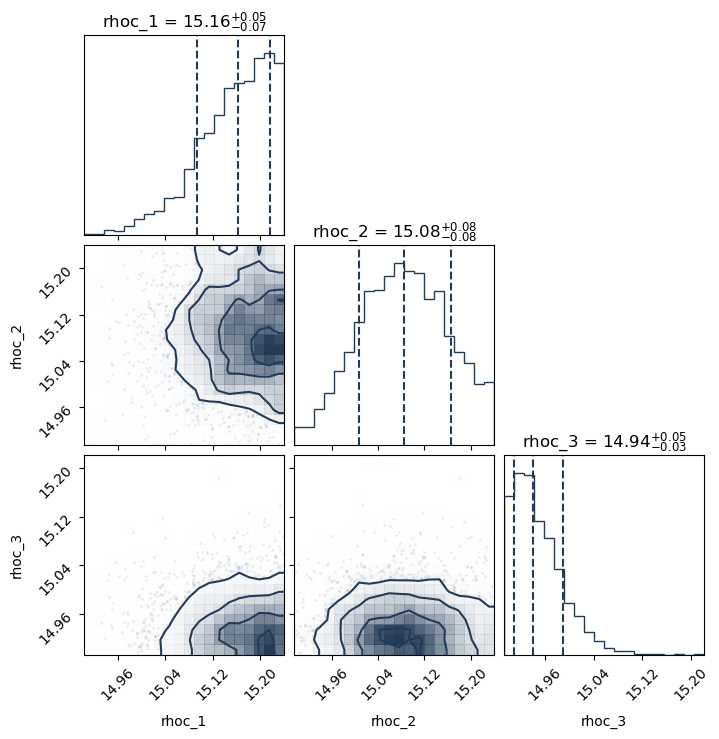

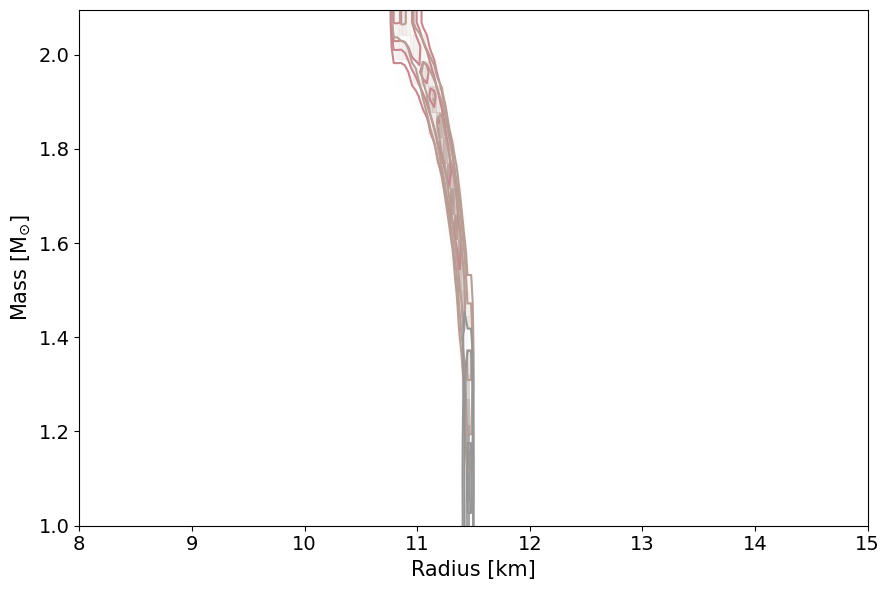

In [11]:
PosteriorAnalysis.mass_radius_posterior_plot('../../examples/chains/' + run_name)

This routine will plot the posterior on the mass-radius relationship of neutron stars according to the inference process, the `label_name` parameter will be the label used in the legend. Note, for the tabulated equation of state with no varying equation of state parameters, one cannot make the below `PosteriorAnalysis.py` files since EoS is tabulated and cannot be varied. If you do try to run these, the code will throw an `Error` message stating that you cannot do this. 